In [1]:
# Add ldcpy root to system path
import sys
import struct
from math import log2

import astropy
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '../../../')

# Import ldcpy package
# Autoreloads package everytime the package is called, so changes to code will be reflected in the notebook if the above sys.path.insert(...) line is uncommented.
# %load_ext 
# %autoreload 2

# suppress all of the divide by zero warnings
import warnings

warnings.filterwarnings("ignore")

import ldcpy

# display the plots in this notebook
%matplotlib inline

In [2]:
import os
os.environ["HDF5_PLUGIN_PATH"]

'/glade/work/haiyingx/H5Z-ZFP-PLUGIN-unbiased/plugin'

In [3]:
# col_ts is a collection containing TS data
col_ts = ldcpy.open_datasets(
    "cam-fv",
    ["TS"],
    [
        "../../../data/cam-fv/orig.TS.100days.nc",
        "../../../data/cam-fv/zfp1e-1.TS.100days.nc",
        "../../../data/cam-fv/zfp1.0.TS.100days.nc",
    ],
    ["orig", "zfpA1e-1", "zfpA1.0"],
)
# col_prect contains PRECT data
col_prect = ldcpy.open_datasets(
    "cam-fv",
    ["PRECT"],
    [
        "../../../data/cam-fv/orig.PRECT.60days.nc",
        "../../../data/cam-fv/zfp1e-11.PRECT.60days.nc",
        "../../../data/cam-fv/zfp1e-7.PRECT.60days.nc",
    ],
    ["orig", "zfpA1e-11", "zfpA1e-7"],
)

ts_array = np.array(col_ts["TS"].isel(time=0).values)
prect_array = np.array(col_prect["PRECT"].isel(time=0).values)

# See here for a list of variables with more information:
# https://www.cesm.ucar.edu/projects/community-projects/LENS/data-sets.html

daily_variables = ["TS", "FLNS", "ICEFRAC", "PRECT", "PSL", "Q200",
                   "TAUX", "WSPDSRFAV", "Z500", "FLUT", "LHFLX"]
data_path = "/glade/p/cisl/asap/CAM_lossy_test_data_31/research"

cols_daily = {}
sets = {}
levels = {}
climate_var_arrays = {}

compression_levels = [24, 22, 20, 18, 16, 14, 12, 10, 8]

for variable in daily_variables:
    print(variable)
    
    new_levels = [f"orig_{variable}"]
    new_sets = [f"{data_path}/daily_orig/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"]
    
    for value in compression_levels:
        new_level = f"zfp_p_{value}_{variable}"
        new_set = f"{data_path}/daily_zfp_hdf5/zfp_p_{value}/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"
        
        new_levels.append(new_level)
        new_sets.append(new_set)
        
    levels[variable] = new_levels
    sets[variable] = new_sets
    
    cols_daily[variable] = ldcpy.open_datasets("cam-fv", [f"{variable}"], sets[variable], levels[variable], chunks={"time":700})
    climate_var_arrays[variable] = np.array(cols_daily[variable][variable].isel(time=0).values)

# array indexing example
# climate_var_arrays["TS"]

dataset size in GB 0.07

dataset size in GB 0.04

TS
dataset size in GB 1.62

FLNS
dataset size in GB 1.62

ICEFRAC
dataset size in GB 1.62

PRECT
dataset size in GB 1.62

PSL
dataset size in GB 1.62

Q200
dataset size in GB 1.62

TAUX
dataset size in GB 1.62

WSPDSRFAV
dataset size in GB 1.62

Z500
dataset size in GB 1.62

FLUT
dataset size in GB 1.62

LHFLX
dataset size in GB 1.62



In [4]:
def binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

# def binary(f):
#     def int_to_8bit_binary_string(n):
#         stg=bin(n).replace('0b','')
#         fillstg = '0'*(8-len(stg))
#         return fillstg+stg
#     return ''.join( int_to_8bit_binary_string(int(b)) for b in struct.pack('>f',f) )


# NOTE: They only look backward
def get_prev_bit(bit_pos):
    return [bit_pos[0]-1, bit_pos[1]]

def get_dict_list(selected_data):
        dict_list_H = []
        for i in range(N_BITS-1):
            new_dict = {"00": 0,
                        "01": 0,
                        "10": 0,
                        "11": 0}
            dict_list_H.append(new_dict)
        
        for y in range(1, selected_data.shape[0]):
            for z in range(selected_data.shape[1]):
                bit_pos = [y, z]
                current_data = selected_data[y][z]
                current_data = binary(current_data)

                adj_data_index = get_prev_bit(bit_pos)
                y_adj, z_adj = adj_data_index
                adj_data = selected_data[y_adj][z_adj]
                adj_data = binary(adj_data)

                for i in range(N_BITS-1):
                    current_bit = int(current_data[i])
                    adjacent_bit = int(adj_data[i])

                    p00 = p01 = p10 = p11 = 0
                    if current_bit == 0 and adjacent_bit == 0:
                        p00 = 1
                    elif current_bit == 0 and adjacent_bit == 1:
                        p01 = 1
                    elif current_bit == 1 and adjacent_bit == 0:
                        p10 = 1
                    elif current_bit == 1 and adjacent_bit == 1:
                        p11 = 1

                    dict_list_H[i]["00"] += p00
                    dict_list_H[i]["01"] += p01
                    dict_list_H[i]["10"] += p10
                    dict_list_H[i]["11"] += p11
                    
        return dict_list_H
    
def get_entropies(dict_list_H, num_measurements):
        bit_pos_H = []
        Hs = []
        diff = []
        for bit_pos_dict in dict_list_H:
            p00 = bit_pos_dict["00"] / num_measurements
            p01 = bit_pos_dict["01"] / num_measurements
            p10 = bit_pos_dict["10"] / num_measurements
            p11 = bit_pos_dict["11"] / num_measurements

            p0 = p00 + p01
            p1 = p10 + p11

            H = 0
            if p0 != 0:
                H -= p0*log2(p0)
            if p1 != 0:
                H -= p1*log2(p1)

            Hs.append(H)

            H0 = 0
            if p00 != 0:
                H0 += p00 * log2(p00)

            if p01 != 0:
                H0 += p01 * log2(p01)

            H1 = 0
            if p10 != 0:
                H1 += p10 * log2(p10)

            if p11 != 0:
                H1 += p11 * log2(p11)

            prob_H = -p0*H0 - p1*H1

            bit_pos_H.append(prob_H)

            diff.append(H - prob_H)
            
        return diff
    

N_BITS = 32

def getbpe(data_array, x_index, title):
    selected_data = data_array[x_index]
              
    dict_list_H = get_dict_list(selected_data)
    
    num_measurements = (selected_data.shape[0] - 1) * selected_data.shape[1]
                
    diff = get_entropies(dict_list_H, num_measurements)
        
    compression_levels = [24, 22, 20, 18, 16, 14, 12, 10, 8]
    compression_levels = ["ZFP_" + str(x) for x in compression_levels]
    compression_levels = ["Orig"] + compression_levels
    
    diff = np.array(diff)
    
    return diff


16 None


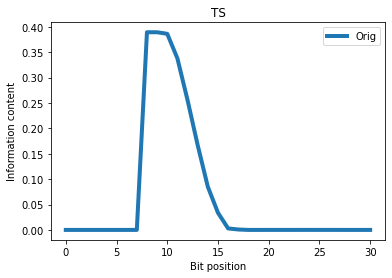

11 None


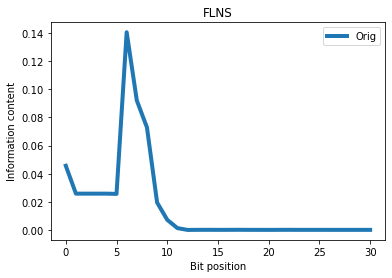

31 None


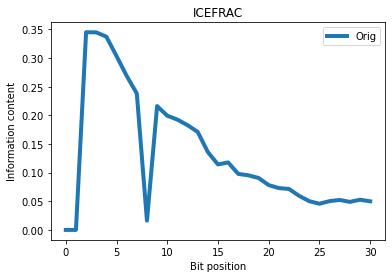

8 None


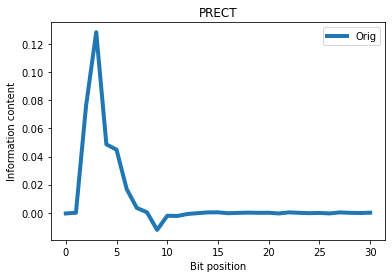

17 None


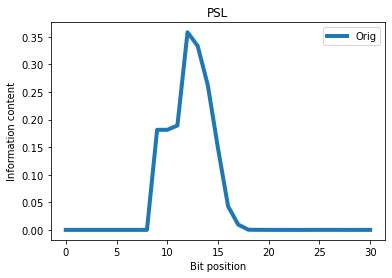

11 None


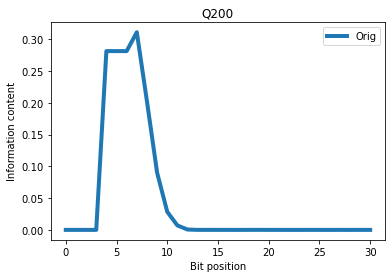

9 None


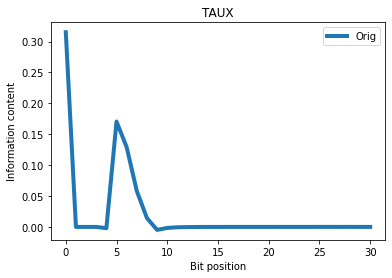

10 None


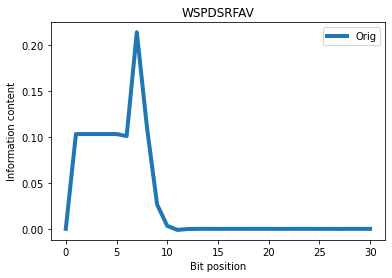

17 None


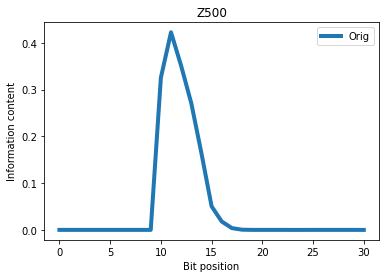

13 None


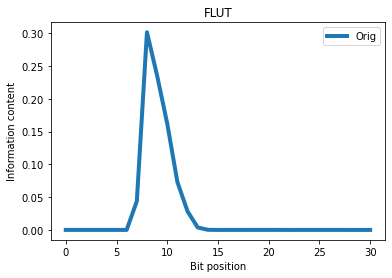

9 None


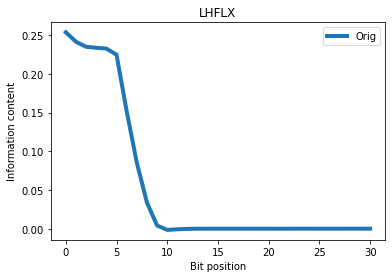

In [20]:
def plot_orig(diff):
    total = np.sum([(0 if x < 0 else x) for x in diff])
    num_bits = 0
    agg = 0
    for loc in diff:
        agg += loc
        num_bits += 1
        if agg > 0.99 * total:
            break
    plt.plot(diff, linewidth=4)
    
    return num_bits
    
        
def plot_compressed(entropy, original_entropy):
    THRESH = 0.001
    
    plt.plot(entropy, '--')
    
    original_entropy[original_entropy < THRESH] = 0
    entropy[original_entropy < THRESH] = 0
    total = np.sum(original_entropy)
    
    diff_area = np.sum(np.abs(original_entropy - entropy))
    
    diff_ratio = diff_area / total
    
    return diff_ratio
    
    
compression_levels = [24, 22, 20, 18, 16, 14, 12, 10, 8]
compression_levels = ["ZFP_" + str(x) for x in compression_levels]
compression_levels = ["Orig"] + compression_levels

num_bits = -1
ENTROPY_RATIO_THRESH = 0.05
best_compression_index = -1

for daily_variable in daily_variables:
    arr = climate_var_arrays[daily_variable]
    original_entropy = None
    etropy_ratio = 0
    for i in range(arr.shape[0]):
        entropy = getbpe(arr, i, daily_variable)
        if i == 0:
            original_entropy = entropy
            num_bits = plot_orig(entropy)
        # else:
            # etropy_ratio = plot_compressed(entropy, original_entropy)
            # # print(etropy_ratio)
            # if etropy_ratio < ENTROPY_RATIO_THRESH:
            #     best_compression_index = i
                
    if best_compression_index == -1:
        best_compression_level = "None"
    else:
        best_compression_level = compression_levels[best_compression_index]
                
    print(num_bits, best_compression_level)
    
    plt.title(daily_variable)
    plt.ylabel("Information content")
    plt.xlabel("Bit position")
    plt.legend(compression_levels)
    # plt.axvline(x=0.5, ls=":")
    # plt.axvline(x=8.5, ls=":")
    plt.show()